In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as torch_models

from torchvision.io import read_image
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torchvision.models import VGG19_Weights, GoogLeNet_Weights, MobileNet_V2_Weights

from PIL import Image

import time
import tqdm

import random
import os

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

torch.manual_seed(16)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset_path = '/kaggle/input/coloncancerct-2025-abdominal-ct-scans/ColonCancerCT-2025 A Dataset of Abdominal CT Scans/Split_Data/Split_Data/train'
names = os.listdir(dataset_path) # Names for visualization
dict_name = {} # Dict for label
for i,name in enumerate(names):
    dict_name[name] = i
n_classe = len(names) # number of classes for models

# Dataset

In [2]:
class ForceRGB:
    def __call__(self, img):
        if isinstance(img, Image.Image):
            return img.convert('RGB')
        elif torch.is_tensor(img) and img.ndim == 3:
            if img.shape[0] == 4:  # RGBA
                return img[:3, :, :]
            elif img.shape[0] == 1:  # Grayscale
                return img.expand(3, -1, -1)
            else:
                return img
        else:
            raise ValueError("Unsupported image type or shape")

transforms = v2.Compose([
    ForceRGB(),
    v2.Resize(size=(224 , 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.1527, 0.1527, 0.1527], std=[0.2484, 0.2484, 0.2484])

])

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
        data = []
        corrupted_count = 0
        
        for label in os.listdir(self.img_dir):
            label_path = os.path.join(self.img_dir, label)
            if not os.path.isdir(label_path):
                continue
                
            for name in os.listdir(label_path):
                img_path = os.path.join(self.img_dir, label, name)
                
                # Verify Image
                if self._is_valid_image(img_path):
                    data.append({'img': str(img_path), 'label': dict_name[label]})
                else:
                    corrupted_count += 1
                    print(f"Skipped Image: {img_path}")
        
        self.img_labels = pd.DataFrame(data)
        print(f"Dataset initialized with {len(self.img_labels)} valid images. Skipped {corrupted_count} corrupted images.")
    
    def _is_valid_image(self, img_path):
        try:
            img = read_image(img_path)
            if img.numel() == 0: 
                return False
            if img.shape[1] < 10 or img.shape[2] < 10: 
                return False
            return True
            
        except Exception as e:
            return False
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        label = self.img_labels.iloc[idx, 1]
        
        try:
            image = read_image(img_path)
            
            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                label = self.target_transform(label)
                
            return image, label
            
        except Exception as e:
            return self.__getitem__((idx + 1) % len(self))

In [4]:
train_dataset = CustomImageDataset(dataset_path, transforms)

Dataset initialized with 7937 valid images. Skipped 0 corrupted images.


# Visualize

In [5]:
def visualize_sample(dataset,nb=4):
    n = random.sample(range(0,len(dataset)), nb) 

    fig, axs = plt.subplots(2, int(np.ceil(nb / 2)), figsize=(12, 8))

    for i in range(axs.shape[0]):
        for j in range(axs.shape[1]):
            if n != []:
                img = np.squeeze(dataset[n[0]][0].permute(1, 2, 0))
                axs[i,j].imshow(img)
                axs[i,j].set_title(f'Label : {names[dataset[n[0]][1]]}')
                axs[i,j].axis("off")
                n.pop(0)
          
    plt.axis('off')

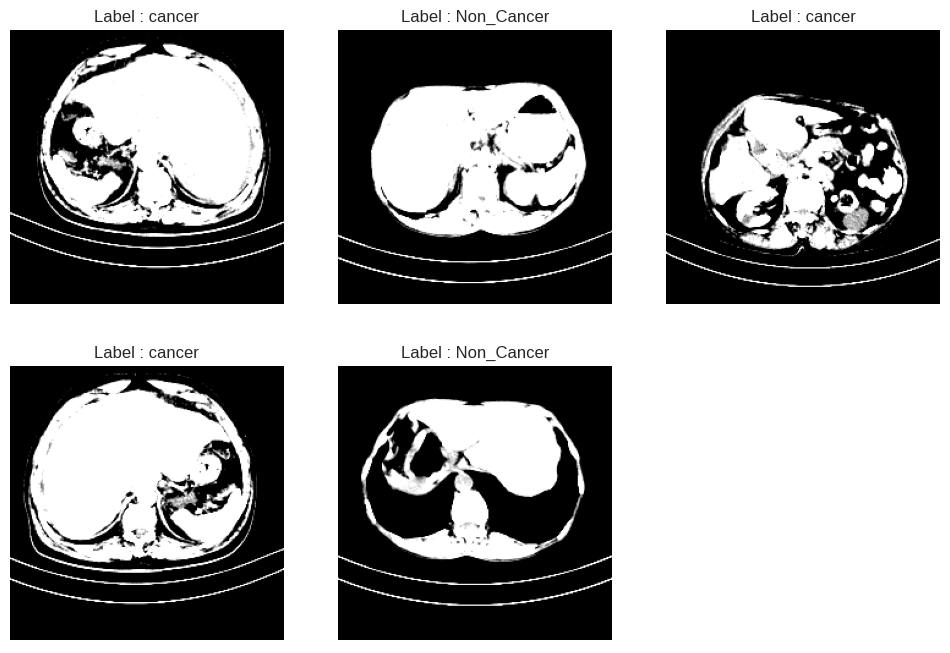

In [6]:
visualize_sample(train_dataset,5)

# Dataloader

In [7]:
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# VGG19

In [8]:
class VGG19(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG19, self).__init__()

        # Feature extraction layers: Convolutional and pooling layers
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                3, 64, kernel_size=3, padding=1
            ),  # 3 input channels, 64 output channels, 3x3 kernel, 1 padding
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, stride=2
            ),  # Max pooling with 2x2 kernel and stride 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Pooling Layer
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))

        # Fully connected layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(
                512 * 7 * 7, 4096
            ),  # 512 channels, 7x7 spatial dimensions after max pooling
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer with 0.5 dropout probability
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),  # Output layer with 'num_classes' output units
        )

    def forward(self, x):
        x = self.feature_extractor(x)  # Pass input through the feature extractor layers
        x = self.avgpool(x)  # Pass Data through a pooling layer
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.classifier(x)  # Pass flattened output through the classifier layers
        return x

# GoogLeNet

In [9]:
class BaseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BaseConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x


class InceptionModule(nn.Module):
    def __init__(self, in_channels, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_proj):
        super(InceptionModule, self).__init__()

        self.b1 = nn.Sequential(
            nn.Conv2d(in_channels, n1x1, kernel_size=1),
            nn.ReLU(True),
        )

        self.b2 = nn.Sequential(
            BaseConv2d(in_channels, n3x3red, kernel_size=1),
            BaseConv2d(n3x3red, n3x3, kernel_size=3, padding=1),
        )

        self.b3 = nn.Sequential(
            BaseConv2d(in_channels, n5x5red, kernel_size=1),
            BaseConv2d(n5x5red, n5x5, kernel_size=5, padding=2),
        )

        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            BaseConv2d(in_channels, pool_proj, kernel_size=1),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1, y2, y3, y4], 1)


class AuxiliaryClassifier(nn.Module):
    def __init__(self, in_channels, num_classes, dropout=0.7):
        super(AuxiliaryClassifier, self).__init__()
        self.pool = nn.AvgPool2d(5, stride=3)
        self.conv = BaseConv2d(in_channels, 128, kernel_size=1)
        self.relu = nn.ReLU(True)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000, use_aux=True):
        super(GoogLeNet, self).__init__()

        self.use_aux = use_aux
        ## block 1
        self.conv1 = BaseConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.lrn1 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, padding=1)

        ## block 2
        self.conv2 = BaseConv2d(64, 64, kernel_size=1)
        self.conv3 = BaseConv2d(64, 192, kernel_size=3, padding=1)
        self.lrn2 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, padding=1)

        ## block 3
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, padding=1)

        ## block 4
        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, padding=1)

        ## block 5
        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        ## auxiliary classifier
        if self.use_aux:
            self.aux1 = AuxiliaryClassifier(512, num_classes)
            self.aux2 = AuxiliaryClassifier(528, num_classes)

        ## block 6
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        ## block 1
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.lrn1(x)

        ## block 2
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.lrn2(x)
        x = self.maxpool2(x)

        ## block 3
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        ## block 4
        x = self.inception4a(x)
        if self.use_aux:
            aux1 = self.aux1(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.use_aux:
            aux2 = self.aux2(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        ## block 5
        x = self.inception5a(x)
        x = self.inception5b(x)

        ## block 6
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        if self.use_aux:
            return x, aux1, aux2
        else:
            return x

# MobileNet

In [10]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            groups=in_channels,
        )
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class MobileNet(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)

        # MobileNet body
        self.dw_conv2 = DepthwiseSeparableConv(32, 64, 1)
        self.dw_conv3 = DepthwiseSeparableConv(64, 128, 2)
        self.dw_conv4 = DepthwiseSeparableConv(128, 128, 1)
        self.dw_conv5 = DepthwiseSeparableConv(128, 256, 2)
        self.dw_conv6 = DepthwiseSeparableConv(256, 256, 1)
        self.dw_conv7 = DepthwiseSeparableConv(256, 512, 2)

        # 5 depthwise separable convolutions with stride 1
        self.dw_conv8 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv9 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv10 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv11 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv12 = DepthwiseSeparableConv(512, 512, 1)

        self.dw_conv13 = DepthwiseSeparableConv(512, 1024, 2)
        self.dw_conv14 = DepthwiseSeparableConv(1024, 1024, 1)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.dw_conv2(x)
        x = F.relu(x)
        x = self.dw_conv3(x)
        x = F.relu(x)
        x = self.dw_conv4(x)
        x = F.relu(x)
        x = self.dw_conv5(x)
        x = F.relu(x)
        x = self.dw_conv6(x)
        x = F.relu(x)
        x = self.dw_conv7(x)
        x = F.relu(x)

        x = self.dw_conv8(x)
        x = F.relu(x)
        x = self.dw_conv9(x)
        x = F.relu(x)
        x = self.dw_conv10(x)
        x = F.relu(x)
        x = self.dw_conv11(x)
        x = F.relu(x)
        x = self.dw_conv12(x)
        x = F.relu(x)

        x = self.dw_conv13(x)
        x = F.relu(x)
        x = self.dw_conv14(x)
        x = F.relu(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Train

In [11]:
def train_model(model, train_loader, device, name, num_epochs=10):
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    
    print(f"Starting training for model: {name} on device: {device}")

    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            if name == 'GoogLeNet':
                loss_main = criterion(outputs[0], labels)
                loss_aux1 = criterion(outputs[1], labels)
                loss_aux2 = criterion(outputs[2], labels)
                loss = loss_main + 0.3 * loss_aux1 + 0.3 * loss_aux2
            else:
                loss = criterion(outputs, labels)

            optimizer.zero_grad() 
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            running_loss += loss.item() 
            if name == 'GoogLeNet':
                _, predicted = outputs[0].max(1)
            else:
                _, predicted = outputs.max(1)
            total += labels.size(0) 
            correct += predicted.eq(labels).sum().item() 

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        scheduler.step(train_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')

    print("Training complete.")
    return model

In [12]:
models = {
    'VGG':VGG19(n_classe),
    'GoogLeNet':GoogLeNet(n_classe),
    'MobileNet':MobileNet(n_classe)
}

In [13]:
trained_models=[]
for name,model in models.items():
    print(f'{name}\n')
    start = time.time()
    
    trained_model = train_model(model, dataloader, device, name, 10)
    trained_models.append(trained_model)

    end = time.time()
    print(f"Runtime : {end - start:.4f} sec")
    print('==='*10,'\n')

VGG

Starting training for model: VGG on device: cuda


Epoch 1/10: 100%|██████████| 249/249 [02:11<00:00,  1.90it/s]


Epoch 1/10, Train Loss: 0.6759, Train Acc: 59.90%


Epoch 2/10: 100%|██████████| 249/249 [02:08<00:00,  1.94it/s]


Epoch 2/10, Train Loss: 0.6752, Train Acc: 59.98%


Epoch 3/10: 100%|██████████| 249/249 [02:07<00:00,  1.95it/s]


Epoch 3/10, Train Loss: 0.6746, Train Acc: 59.98%


Epoch 4/10: 100%|██████████| 249/249 [02:08<00:00,  1.95it/s]


Epoch 4/10, Train Loss: 0.6755, Train Acc: 59.98%


Epoch 5/10: 100%|██████████| 249/249 [02:09<00:00,  1.92it/s]


Epoch 5/10, Train Loss: 0.6734, Train Acc: 59.98%


Epoch 6/10: 100%|██████████| 249/249 [02:10<00:00,  1.92it/s]


Epoch 6/10, Train Loss: 0.6732, Train Acc: 59.98%


Epoch 7/10: 100%|██████████| 249/249 [02:09<00:00,  1.92it/s]


Epoch 7/10, Train Loss: 0.6745, Train Acc: 59.98%


Epoch 8/10: 100%|██████████| 249/249 [02:10<00:00,  1.90it/s]


Epoch 8/10, Train Loss: 0.6752, Train Acc: 59.98%


Epoch 9/10: 100%|██████████| 249/249 [02:10<00:00,  1.91it/s]


Epoch 9/10, Train Loss: 0.6728, Train Acc: 59.98%


Epoch 10/10: 100%|██████████| 249/249 [02:08<00:00,  1.94it/s]


Epoch 10/10, Train Loss: 0.6761, Train Acc: 59.98%
Training complete.
Runtime : 1294.1100 sec

GoogLeNet

Starting training for model: GoogLeNet on device: cuda


Epoch 1/10: 100%|██████████| 249/249 [01:19<00:00,  3.14it/s]


Epoch 1/10, Train Loss: 1.0788, Train Acc: 59.91%


Epoch 2/10: 100%|██████████| 249/249 [01:18<00:00,  3.19it/s]


Epoch 2/10, Train Loss: 1.0759, Train Acc: 59.98%


Epoch 3/10: 100%|██████████| 249/249 [01:18<00:00,  3.17it/s]


Epoch 3/10, Train Loss: 0.8833, Train Acc: 69.09%


Epoch 4/10: 100%|██████████| 249/249 [01:18<00:00,  3.18it/s]


Epoch 4/10, Train Loss: 0.5714, Train Acc: 83.42%


Epoch 5/10: 100%|██████████| 249/249 [01:18<00:00,  3.16it/s]


Epoch 5/10, Train Loss: 0.3611, Train Acc: 90.84%


Epoch 6/10: 100%|██████████| 249/249 [01:18<00:00,  3.17it/s]


Epoch 6/10, Train Loss: 0.2784, Train Acc: 92.91%


Epoch 7/10: 100%|██████████| 249/249 [01:17<00:00,  3.20it/s]


Epoch 7/10, Train Loss: 0.2073, Train Acc: 95.33%


Epoch 8/10: 100%|██████████| 249/249 [01:18<00:00,  3.16it/s]


Epoch 8/10, Train Loss: 0.1687, Train Acc: 95.94%


Epoch 9/10: 100%|██████████| 249/249 [01:19<00:00,  3.14it/s]


Epoch 9/10, Train Loss: 0.1558, Train Acc: 96.70%


Epoch 10/10: 100%|██████████| 249/249 [01:18<00:00,  3.17it/s]


Epoch 10/10, Train Loss: 0.1475, Train Acc: 96.80%
Training complete.
Runtime : 786.1348 sec

MobileNet

Starting training for model: MobileNet on device: cuda


Epoch 1/10: 100%|██████████| 249/249 [01:06<00:00,  3.72it/s]


Epoch 1/10, Train Loss: 0.6775, Train Acc: 59.93%


Epoch 2/10: 100%|██████████| 249/249 [01:07<00:00,  3.68it/s]


Epoch 2/10, Train Loss: 0.6755, Train Acc: 59.98%


Epoch 3/10: 100%|██████████| 249/249 [01:08<00:00,  3.62it/s]


Epoch 3/10, Train Loss: 0.6734, Train Acc: 59.98%


Epoch 4/10: 100%|██████████| 249/249 [01:07<00:00,  3.70it/s]


Epoch 4/10, Train Loss: 0.6735, Train Acc: 59.98%


Epoch 5/10: 100%|██████████| 249/249 [01:08<00:00,  3.63it/s]


Epoch 5/10, Train Loss: 0.6733, Train Acc: 59.98%


Epoch 6/10: 100%|██████████| 249/249 [01:08<00:00,  3.64it/s]


Epoch 6/10, Train Loss: 0.6747, Train Acc: 59.98%


Epoch 7/10: 100%|██████████| 249/249 [01:07<00:00,  3.66it/s]


Epoch 7/10, Train Loss: 0.6734, Train Acc: 59.98%


Epoch 8/10: 100%|██████████| 249/249 [01:08<00:00,  3.61it/s]


Epoch 8/10, Train Loss: 0.6724, Train Acc: 59.98%


Epoch 9/10: 100%|██████████| 249/249 [01:08<00:00,  3.64it/s]


Epoch 9/10, Train Loss: 0.6737, Train Acc: 59.98%


Epoch 10/10: 100%|██████████| 249/249 [01:08<00:00,  3.64it/s]

Epoch 10/10, Train Loss: 0.6731, Train Acc: 59.98%
Training complete.
Runtime : 681.5598 sec



## Using Pre-trained models

In [14]:
class PretrainedVGG19(nn.Module):
    def __init__(self, num_classes=10, freeze_features=True):
        super(PretrainedVGG19, self).__init__()
        
        self.vgg19 = torch_models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
        
        if freeze_features:
            for param in self.vgg19.features.parameters():
                param.requires_grad = False
        
        self.vgg19.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        return self.vgg19(x)


class PretrainedGoogLeNet(nn.Module):
    def __init__(self, num_classes=10, freeze_features=True):
        super(PretrainedGoogLeNet, self).__init__()
        
        self.googlenet = torch_models.googlenet(weights=GoogLeNet_Weights.IMAGENET1K_V1)
        
        if freeze_features:
            for name, param in self.googlenet.named_parameters():
                if 'fc' not in name: 
                    param.requires_grad = False
        self.googlenet.fc = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        return self.googlenet(x)


class PretrainedMobileNetV2(nn.Module):
    def __init__(self, num_classes=10, freeze_features=True):
        super(PretrainedMobileNetV2, self).__init__()
        
        self.mobilenet = torch_models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        
        if freeze_features:
            for param in self.mobilenet.features.parameters():
                param.requires_grad = False
        
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes)
        )
    
    def forward(self, x):
        return self.mobilenet(x)

In [15]:
models_pt = {
    'VGG':PretrainedVGG19(n_classe),
    'GoogLeNet':PretrainedGoogLeNet(n_classe),
    'MobileNet':PretrainedMobileNetV2(n_classe)
}

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 237MB/s]
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 216MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 158MB/s]


In [16]:
pt_trained_models=[]
for name,model in models_pt.items():
    print(f'{name}\n')
    start = time.time()
    
    trained_model = train_model(model, dataloader, device, name + '_pt', 10)
    pt_trained_models.append(trained_model)

    end = time.time()
    print(f"Runtime : {end - start:.4f} sec")
    print('==='*10,'\n')

VGG

Starting training for model: VGG_pt on device: cuda


Epoch 1/10: 100%|██████████| 249/249 [01:24<00:00,  2.95it/s]


Epoch 1/10, Train Loss: 0.3565, Train Acc: 84.89%


Epoch 2/10: 100%|██████████| 249/249 [01:23<00:00,  2.97it/s]


Epoch 2/10, Train Loss: 0.1475, Train Acc: 95.05%


Epoch 3/10: 100%|██████████| 249/249 [01:23<00:00,  2.99it/s]


Epoch 3/10, Train Loss: 0.1147, Train Acc: 96.62%


Epoch 4/10: 100%|██████████| 249/249 [01:23<00:00,  3.00it/s]


Epoch 4/10, Train Loss: 0.0810, Train Acc: 97.64%


Epoch 5/10: 100%|██████████| 249/249 [01:22<00:00,  3.00it/s]


Epoch 5/10, Train Loss: 0.0555, Train Acc: 98.63%


Epoch 6/10: 100%|██████████| 249/249 [01:23<00:00,  3.00it/s]


Epoch 6/10, Train Loss: 0.0546, Train Acc: 98.68%


Epoch 7/10: 100%|██████████| 249/249 [01:23<00:00,  2.98it/s]


Epoch 7/10, Train Loss: 0.0459, Train Acc: 98.95%


Epoch 8/10: 100%|██████████| 249/249 [01:22<00:00,  3.00it/s]


Epoch 8/10, Train Loss: 0.0523, Train Acc: 98.88%


Epoch 9/10: 100%|██████████| 249/249 [01:22<00:00,  3.01it/s]


Epoch 9/10, Train Loss: 0.0387, Train Acc: 99.07%


Epoch 10/10: 100%|██████████| 249/249 [01:22<00:00,  3.00it/s]


Epoch 10/10, Train Loss: 0.0383, Train Acc: 99.23%
Training complete.
Runtime : 832.8820 sec

GoogLeNet

Starting training for model: GoogLeNet_pt on device: cuda


Epoch 1/10: 100%|██████████| 249/249 [01:00<00:00,  4.10it/s]


Epoch 1/10, Train Loss: 0.6494, Train Acc: 62.93%


Epoch 2/10: 100%|██████████| 249/249 [00:59<00:00,  4.21it/s]


Epoch 2/10, Train Loss: 0.5905, Train Acc: 69.45%


Epoch 3/10: 100%|██████████| 249/249 [01:00<00:00,  4.14it/s]


Epoch 3/10, Train Loss: 0.5562, Train Acc: 73.69%


Epoch 4/10: 100%|██████████| 249/249 [01:00<00:00,  4.12it/s]


Epoch 4/10, Train Loss: 0.5335, Train Acc: 74.61%


Epoch 5/10: 100%|██████████| 249/249 [00:58<00:00,  4.23it/s]


Epoch 5/10, Train Loss: 0.5142, Train Acc: 76.20%


Epoch 6/10: 100%|██████████| 249/249 [00:58<00:00,  4.22it/s]


Epoch 6/10, Train Loss: 0.5050, Train Acc: 76.91%


Epoch 7/10: 100%|██████████| 249/249 [00:59<00:00,  4.22it/s]


Epoch 7/10, Train Loss: 0.4865, Train Acc: 77.66%


Epoch 8/10: 100%|██████████| 249/249 [00:58<00:00,  4.24it/s]


Epoch 8/10, Train Loss: 0.4825, Train Acc: 78.71%


Epoch 9/10: 100%|██████████| 249/249 [00:58<00:00,  4.23it/s]


Epoch 9/10, Train Loss: 0.4738, Train Acc: 78.82%


Epoch 10/10: 100%|██████████| 249/249 [00:58<00:00,  4.26it/s]


Epoch 10/10, Train Loss: 0.4644, Train Acc: 79.34%
Training complete.
Runtime : 593.6784 sec

MobileNet

Starting training for model: MobileNet_pt on device: cuda


Epoch 1/10: 100%|██████████| 249/249 [00:57<00:00,  4.35it/s]


Epoch 1/10, Train Loss: 0.6003, Train Acc: 68.09%


Epoch 2/10: 100%|██████████| 249/249 [00:59<00:00,  4.21it/s]


Epoch 2/10, Train Loss: 0.5143, Train Acc: 75.65%


Epoch 3/10: 100%|██████████| 249/249 [00:59<00:00,  4.17it/s]


Epoch 3/10, Train Loss: 0.4738, Train Acc: 77.71%


Epoch 4/10: 100%|██████████| 249/249 [00:59<00:00,  4.15it/s]


Epoch 4/10, Train Loss: 0.4565, Train Acc: 79.09%


Epoch 5/10: 100%|██████████| 249/249 [00:58<00:00,  4.25it/s]


Epoch 5/10, Train Loss: 0.4361, Train Acc: 80.02%


Epoch 6/10: 100%|██████████| 249/249 [00:59<00:00,  4.20it/s]


Epoch 6/10, Train Loss: 0.4288, Train Acc: 80.18%


Epoch 7/10: 100%|██████████| 249/249 [00:59<00:00,  4.22it/s]


Epoch 7/10, Train Loss: 0.4251, Train Acc: 80.74%


Epoch 8/10: 100%|██████████| 249/249 [00:59<00:00,  4.20it/s]


Epoch 8/10, Train Loss: 0.4148, Train Acc: 81.14%


Epoch 9/10: 100%|██████████| 249/249 [00:59<00:00,  4.17it/s]


Epoch 9/10, Train Loss: 0.4115, Train Acc: 80.80%


Epoch 10/10: 100%|██████████| 249/249 [00:59<00:00,  4.20it/s]

Epoch 10/10, Train Loss: 0.4078, Train Acc: 81.88%
Training complete.
Runtime : 591.4923 sec



# Test & Evaluation

In [17]:
dataset_path = '/kaggle/input/coloncancerct-2025-abdominal-ct-scans/ColonCancerCT-2025 A Dataset of Abdominal CT Scans/Split_Data/Split_Data/train'

test_dataset = CustomImageDataset(dataset_path, transforms)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Dataset initialized with 7937 valid images. Skipped 0 corrupted images.


In [18]:
def evaluate_model(model, test_loader, device, model_name):
    model.eval()
    model = model.to(device)
    
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(test_loader, desc=f"Evaluating {model_name}"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            
            if model_name == 'GoogLeNet':
                outputs = outputs[0]  
            
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels), np.array(all_probabilities)

In [19]:
def plot_confusion_matrix(y_true, y_pred, model_name, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.tight_layout()
    plt.show()
    
    return cm

In [20]:
def plot_roc_curves(models_results, class_names):
    n_classes = len(class_names)
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 12))
    axes = axes.flatten()
    
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    
    for class_idx in range(n_classes):
        ax = axes[class_idx] if class_idx < len(axes) else plt.subplot(2, 3, class_idx + 1)
        
        for i, (model_name, (y_pred, y_true, y_prob)) in enumerate(models_results.items()):
            y_true_binary = (y_true == class_idx).astype(int)
            y_prob_class = y_prob[:, class_idx]
            
            fpr, tpr, _ = roc_curve(y_true_binary, y_prob_class)
            roc_auc = auc(fpr, tpr)
            
            ax.plot(fpr, tpr, color=colors[i], lw=2, 
                   label=f'{model_name} (AUC = {roc_auc:.3f})')
        
        ax.plot([0, 1], [0, 1], 'k--', lw=2)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('FP')
        ax.set_ylabel('TP')
        ax.set_title(f'ROC Curve - {class_names[class_idx]}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [21]:
def create_performance_comparison(models_results, class_names):
    metrics_data = []
    
    for model_name, (y_pred, y_true, y_prob) in models_results.items():
        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
        
        try:
            auc_scores = []
            for class_idx in range(len(class_names)):
                y_true_binary = (y_true == class_idx).astype(int)
                y_prob_class = y_prob[:, class_idx]
                auc_score = roc_auc_score(y_true_binary, y_prob_class)
                auc_scores.append(auc_score)
            avg_auc = np.mean(auc_scores)
        except:
            avg_auc = 0
        
        metrics_data.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': avg_auc
        })
    
    df_metrics = pd.DataFrame(metrics_data)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        bars = ax.bar(df_metrics['Model'], df_metrics[metric], alpha=0.7)
        ax.set_title(f'Comparison - {metric}')
        ax.set_ylabel(metric)
        ax.set_ylim(0, 1)
        
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom')
        
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    ax = axes[5]
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]
    
    for _, row in df_metrics.iterrows():
        values = [row[metric] for metric in metrics]
        values += values[:1] 
        
        ax.plot(angles, values, 'o-', linewidth=2, label=row['Model'])
        ax.fill(angles, values, alpha=0.25)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 1)
    ax.set_title('Radar Metric Comparison')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return df_metrics

In [22]:
def create_detailed_report(models_results, class_names):
    print("="*80)
    print("DETAILED MODEL EVALUATION REPORT")
    print("="*80)
    
    for model_name, (y_pred, y_true, y_prob) in models_results.items():
        print(f"\n📊 MODEL: {model_name}")
        print("-" * 50)
        
        accuracy = accuracy_score(y_true, y_pred)
        print(f"🎯 Global Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        
        print("\n📋 Classification report:")
        print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
        
        cm = confusion_matrix(y_true, y_pred)
        print("\n📊 Confusion matrix:")
        print(cm)
        
        print("\n" + "="*50)

In [23]:
def evaluate_all_models(trained_models, pt_trained_models, test_dataloader, device, class_names=None):
    model_names = ['VGG', 'GoogLeNet', 'MobileNet']
    
    models_results = {}
    
    for i, (model_name, model) in enumerate(zip(model_names, trained_models)):
        print(f"\n📊 Model evaluation: {model_name}")
        y_pred, y_true, y_prob = evaluate_model(model, test_dataloader, device, model_name)
        models_results[model_name] = (y_pred, y_true, y_prob)
        
        plot_confusion_matrix(y_true, y_pred, model_name, class_names)
    
    for i, (model_name, model) in enumerate(zip(model_names, pt_trained_models)):
        pt_model_name = f"{model_name}_Pretrained"
        print(f"\n📊 Model evaluation: {pt_model_name}")
        y_pred, y_true, y_prob = evaluate_model(model, test_dataloader, device, 'pt')
        models_results[pt_model_name] = (y_pred, y_true, y_prob)
        
        plot_confusion_matrix(y_true, y_pred, pt_model_name, class_names)
    
    # Créer les comparaisons
    print("\n🎨 Generating ROC curves...")
    plot_roc_curves(models_results, class_names)
    
    print("\n📈 Generate comparison graphs...")
    df_metrics = create_performance_comparison(models_results, class_names)
    
    print("\n📝 Detailed report generation...")
    create_detailed_report(models_results, class_names)
    
    return models_results, df_metrics


📊 Model evaluation: VGG


Evaluating VGG: 100%|██████████| 249/249 [01:17<00:00,  3.22it/s]


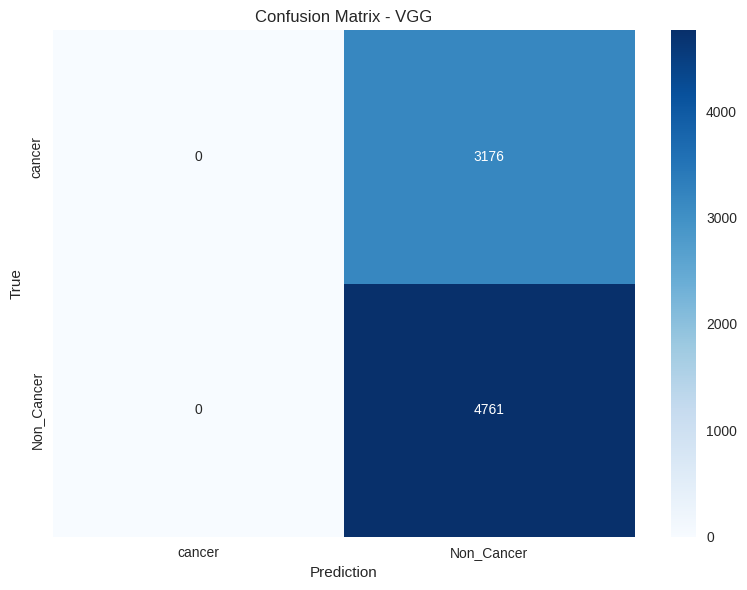


📊 Model evaluation: GoogLeNet


Evaluating GoogLeNet: 100%|██████████| 249/249 [01:02<00:00,  4.01it/s]


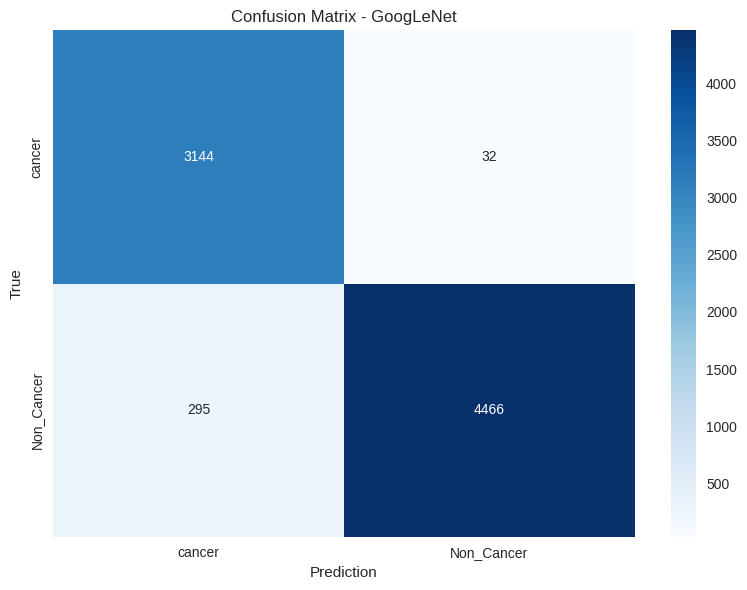


📊 Model evaluation: MobileNet


Evaluating MobileNet: 100%|██████████| 249/249 [00:58<00:00,  4.22it/s]


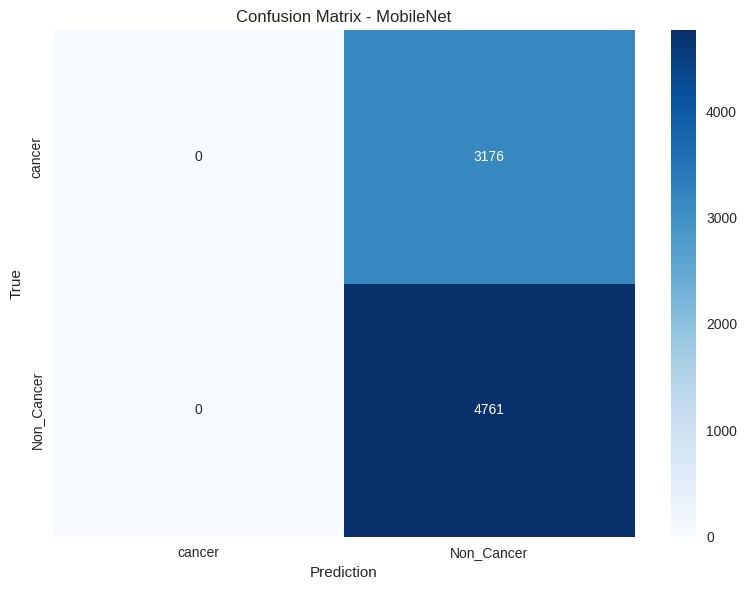


📊 Model evaluation: VGG_Pretrained


Evaluating pt: 100%|██████████| 249/249 [01:18<00:00,  3.17it/s]


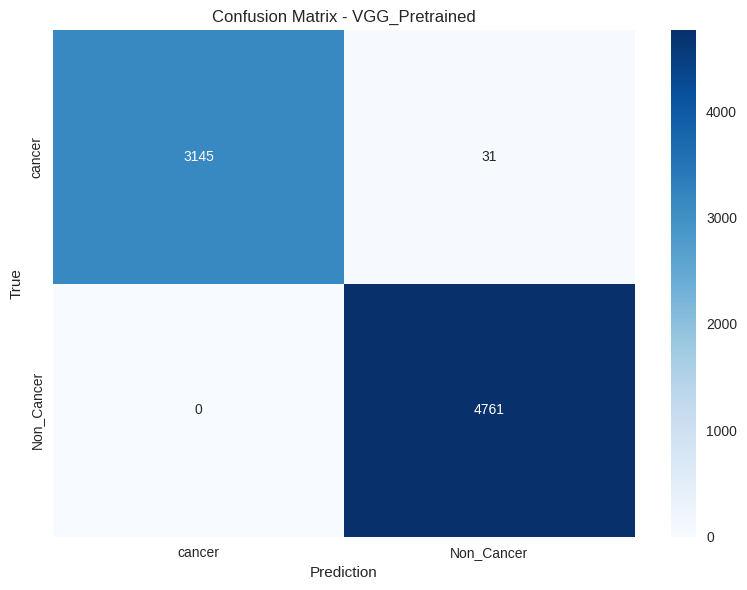


📊 Model evaluation: GoogLeNet_Pretrained


Evaluating pt: 100%|██████████| 249/249 [01:03<00:00,  3.89it/s]


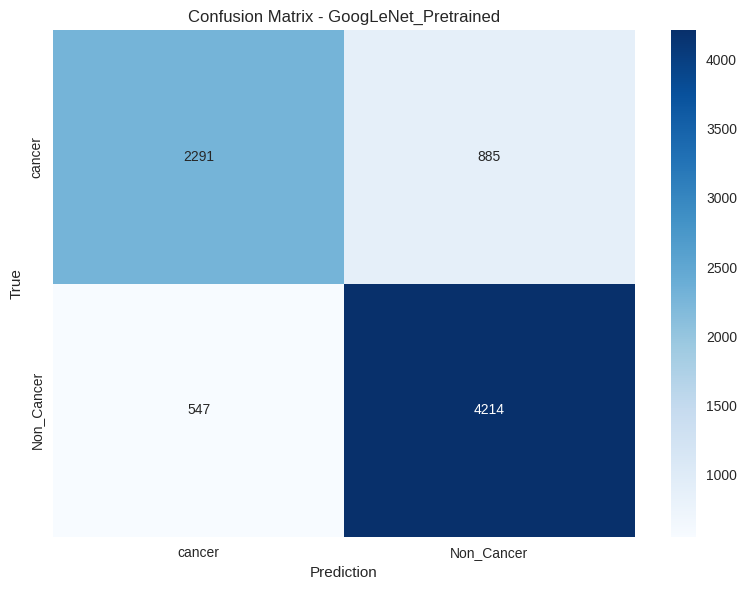


📊 Model evaluation: MobileNet_Pretrained


Evaluating pt: 100%|██████████| 249/249 [00:59<00:00,  4.20it/s]


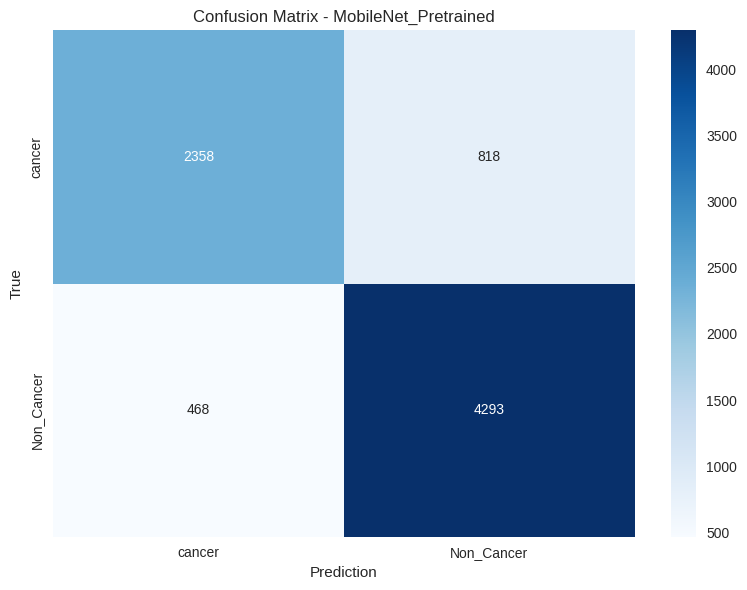


🎨 Generating ROC curves...


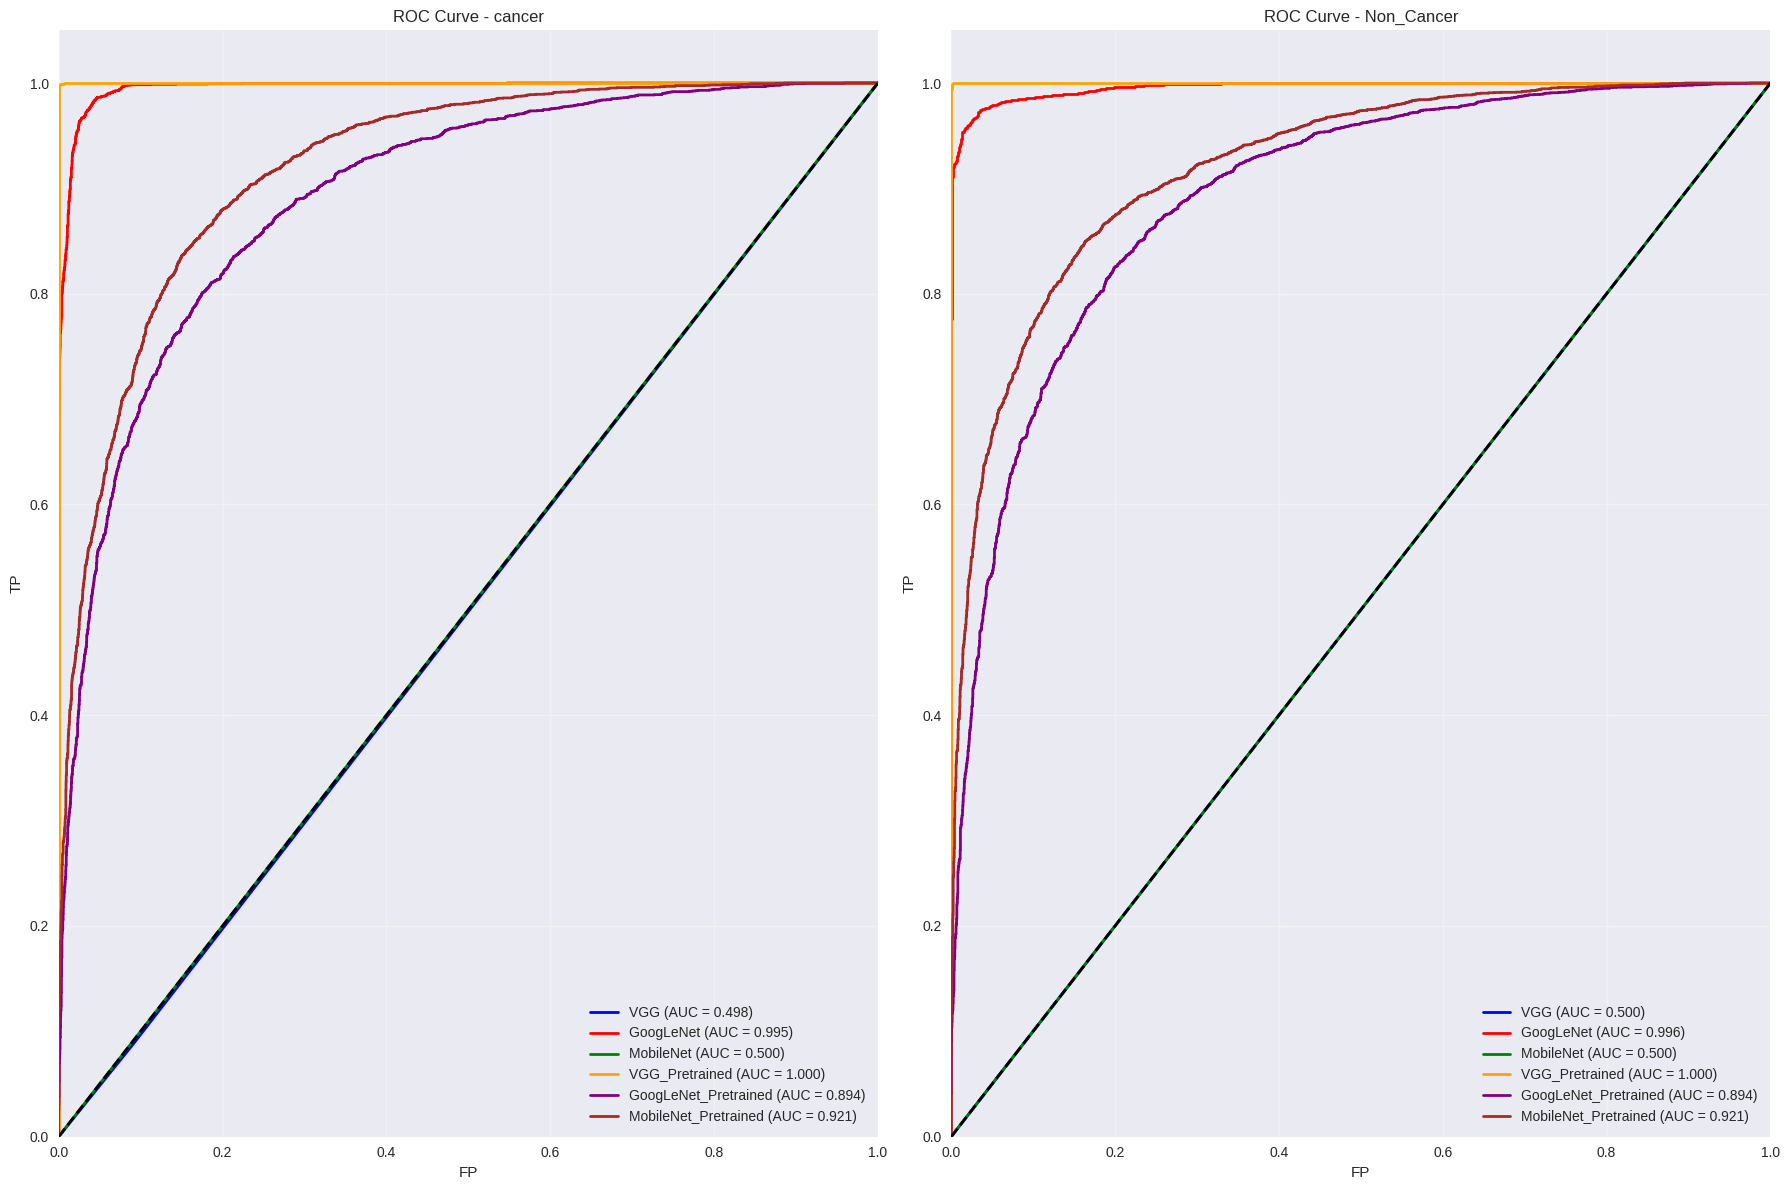


📈 Generate comparison graphs...


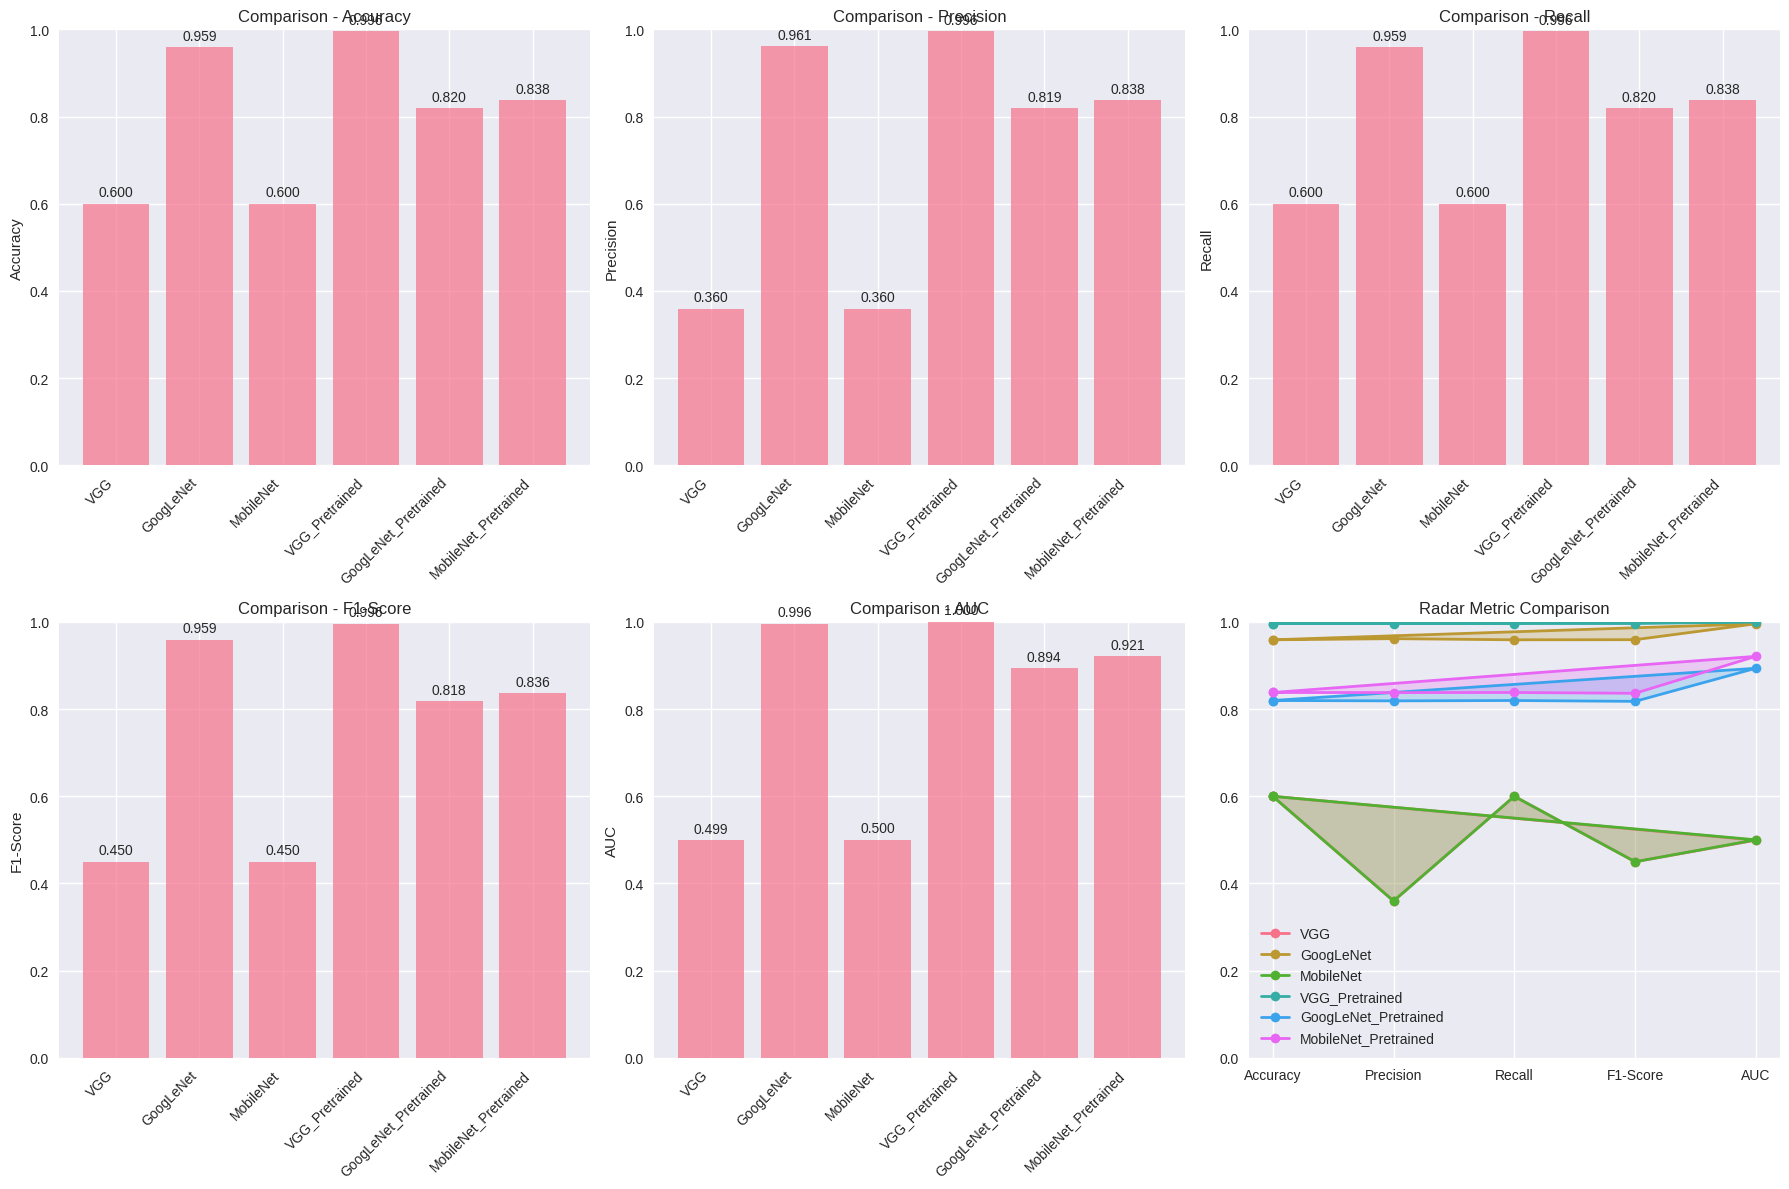


📝 Detailed report generation...
DETAILED MODEL EVALUATION REPORT

📊 MODEL: VGG
--------------------------------------------------
🎯 Global Accuracy: 0.5998 (59.98%)

📋 Classification report:
              precision    recall  f1-score   support

      cancer     0.0000    0.0000    0.0000      3176
  Non_Cancer     0.5998    1.0000    0.7499      4761

    accuracy                         0.5998      7937
   macro avg     0.2999    0.5000    0.3749      7937
weighted avg     0.3598    0.5998    0.4498      7937


📊 Confusion matrix:
[[   0 3176]
 [   0 4761]]


📊 MODEL: GoogLeNet
--------------------------------------------------
🎯 Global Accuracy: 0.9588 (95.88%)

📋 Classification report:
              precision    recall  f1-score   support

      cancer     0.9142    0.9899    0.9506      3176
  Non_Cancer     0.9929    0.9380    0.9647      4761

    accuracy                         0.9588      7937
   macro avg     0.9536    0.9640    0.9576      7937
weighted avg     0.9614    0

In [24]:
results, metrics_df = evaluate_all_models(
    trained_models, 
    pt_trained_models, 
    test_dataloader, 
    device, 
    names
)

In [25]:
print("\n📊 PERFORMANCE SUMMARY TABLE:")
print("="*60)
print(metrics_df.to_string(index=False, float_format='%.4f'))


metrics_df.to_csv('model_comparison_results.csv', index=False)
print("\n💾 Results saved in 'model_comparison_results.csv'")


📊 PERFORMANCE SUMMARY TABLE:
               Model  Accuracy  Precision  Recall  F1-Score    AUC
                 VGG    0.5998     0.3598  0.5998    0.4498 0.4992
           GoogLeNet    0.9588     0.9614  0.9588    0.9590 0.9955
           MobileNet    0.5998     0.3598  0.5998    0.4498 0.5001
      VGG_Pretrained    0.9961     0.9961  0.9961    0.9961 1.0000
GoogLeNet_Pretrained    0.8196     0.8188  0.8196    0.8176 0.8935
MobileNet_Pretrained    0.8380     0.8377  0.8380    0.8361 0.9209

💾 Results saved in 'model_comparison_results.csv'


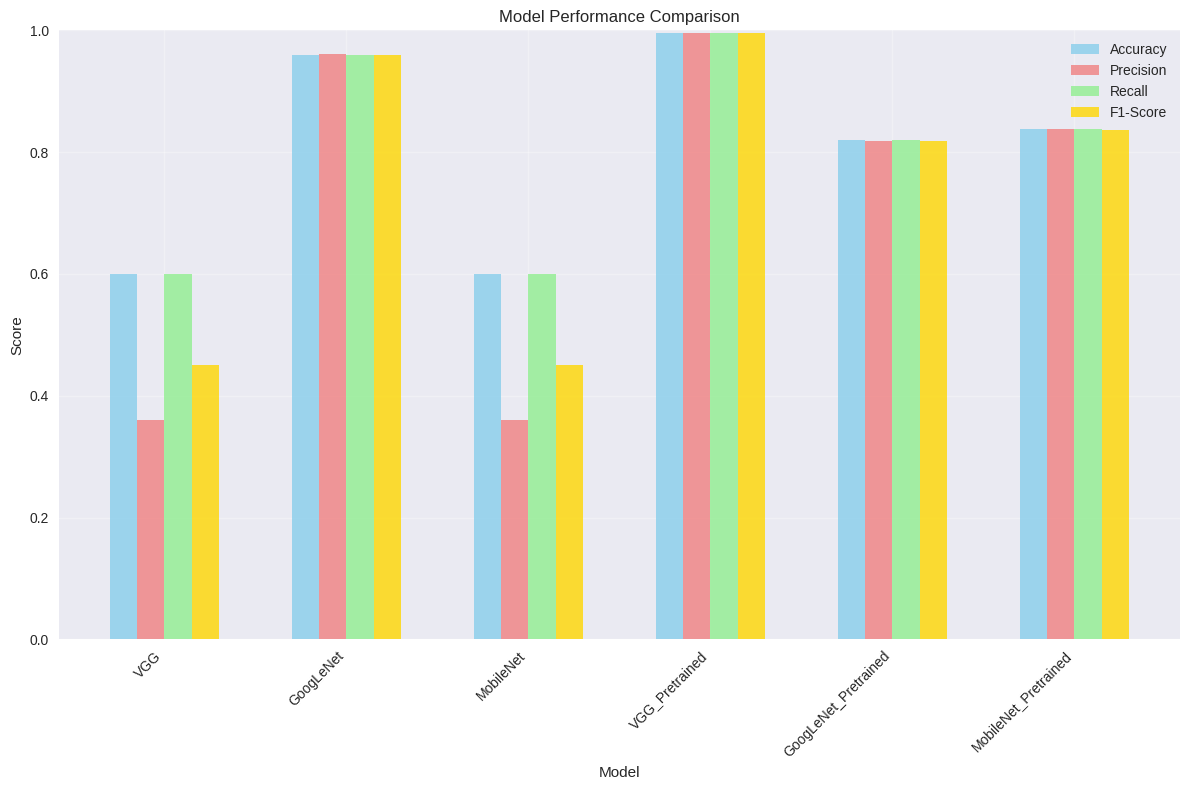

In [26]:
plt.figure(figsize=(12, 8))
x = np.arange(len(metrics_df))
width = 0.15

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*width, metrics_df[metric], width, label=metric, color=colors[i], alpha=0.8)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width*1.5, metrics_df['Model'], rotation=45, ha='right')
plt.legend()
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Conclusion

## Conclusion

In this notebook, I compared three convolutional neural network architectures: VGG19, GoogLeNet, and MobileNet, along with their pre-trained versions. Overall, training from scratch on the base models yielded lower performance. This can be attributed to two main factors: the limited number of images in the dataset and the random initialization of the models.

These architectures were originally designed for the ImageNet dataset, which contains over one million images. As a result, the number of parameters per image in my dataset is significantly higher, leading to potential overfitting and suboptimal training. Pre-trained models, benefiting from learned features on large-scale data, performed better and adapted more efficiently to the task at hand.
